# [Intersection project] 교차로에서 사고나는 시점 측정하기

### metric_depth.npy파일 크기: 1080*1920
### 000000_depth.png파일 크기(원본 프레임 이미지와 크기 동일): 1080*1920

## <depth.png위에 bounding box 점 찍어보기>

Width: 1920, Height: 1080


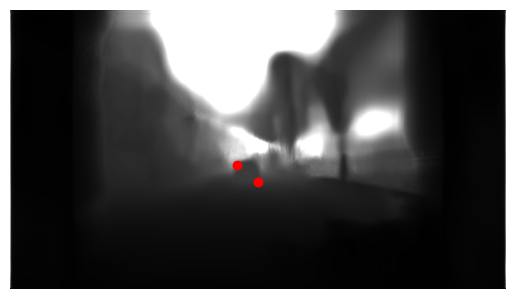

In [102]:
from PIL import Image
import matplotlib.pyplot as plt

# PNG 파일을 불러오기
file_path = 'object_depths/000000_depth.png'
image = Image.open(file_path)
width, height = image.size
print(f"Width: {width}, Height: {height}")

# 이미지 표시 준비
plt.imshow(image)

# 점을 찍고 싶은 좌표 리스트 [(x1, y1), (x2, y2), ...]
points = [(877, 599), (961, 666)]

# 각 좌표에 점을 찍기
for (x, y) in points:
    plt.plot(x, y, 'ro')  # 'ro'는 빨간색 점을 의미합니다.

# 결과 출력
plt.axis('off')  # 축을 숨김
plt.show()


Frame 85 - Average Depths:
vehicle0: 17.859005
vehicle4: 19.978741
vehicle6: 14.888934
vehicle9: 28.918053


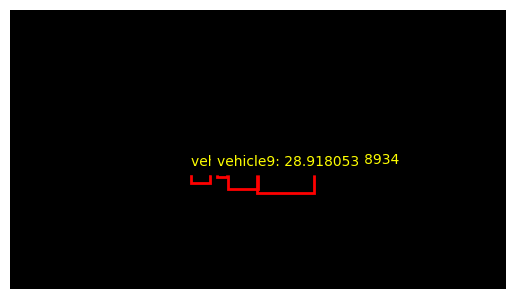

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import glob
import os

# track_data 불러오기
track_data = np.load('tracked_data.npy', allow_pickle=True)


##vehicle count 특정 횟수 이하면 drop
for entry in track_data:
    for vehicle in entry.keys():
        if vehicle in vehicle_count:
            vehicle_count[vehicle] += 1
        else:
            vehicle_count[vehicle] = 1


filtered_data = []
for entry in data:
    filtered_entry = {vehicle: entry[vehicle] for vehicle in entry.keys() if vehicle_count[vehicle] > 2*fps}
    if filtered_entry:  # 필터링된 결과가 비어있지 않으면 추가
        filtered_data.append(filtered_entry)

track_data=filtered_data

# object_depths 폴더에서 모든 *_disparities.npy 파일 찾기
depth_files = sorted(glob.glob('object_depths/*_metric_depth.npy'))

# 비율 조정값 설정 (예시)
change_x = 1  # 실제 이미지 크기에 맞춰 조정하세요
change_y = 1   # 실제 이미지 크기에 맞춰 조정하세요

# 각 프레임에 대해 처리
for frame_index, frame_data in enumerate(track_data):
    if frame_index==85:  # 예시로 85번 프레임만 확인
        fig, ax = plt.subplots()
        
        # 가상의 배경 이미지를 표시 (실제 이미지가 없다면, 이미지 부분을 생략할 수 있음)
        ax.imshow(np.ones((1080, 1920)), cmap='gray')  # 이미지 크기를 대체하세요
        
        # 현재 프레임에 해당하는 깊이 데이터 불러오기
        depth_file = depth_files[frame_index]
        depth_data = np.load(depth_file)

        # 각 차량의 평균 깊이 값을 저장할 딕셔너리
        vehicle_depths = {}

        # 각 차량에 대해 박스와 평균 깊이 계산
        for vehicle_id, coordinates in frame_data.items():
            x_min, y_min, x_max, y_max = coordinates.astype(int)  # 좌표

            c_x_min = int(x_min * change_x)
            c_x_max = int(x_max * change_x)
            c_y_min = int(y_min * change_y)
            c_y_max = int(y_max * change_y)

            # 박스 그리기
            width, height = c_x_max - c_x_min, c_y_max - c_y_min
            rect = Rectangle((c_x_min, c_y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
            # 깊이 데이터 계산
            depth_values = depth_data[c_y_min:c_y_max, c_x_min:c_x_max]

            mean_depth = np.median(depth_values)
            vehicle_depths[vehicle_id] = mean_depth  # 평균 깊이 저장
            
            # 박스 위에 평균 깊이 값 표시
            ax.text(c_x_min, c_y_min - 10, f'{vehicle_id}: {mean_depth:.6f}', color='yellow', fontsize=10, backgroundcolor="black")

        # 각 차량의 평균 깊이 값을 print로 출력
        print(f"Frame {frame_index} - Average Depths:")
        for vehicle_id, mean_depth in vehicle_depths.items():
            print(f"{vehicle_id}: {mean_depth:.6f}")
        
        # 결과 보여주기
        plt.axis('off')
        plt.show()


## 1. 사고나는 프레임 구하기
### bounding box가 접하면서 depth값이 임계값 이하로 떨어지는 프레임 찾기(모든 차량에 대해 적용)

In [104]:
import numpy as np
import glob

# track_data 불러오기
track_data = np.load('tracked_data.npy', allow_pickle=True)

# object_depths 폴더에서 모든 *_metric.npy 파일 찾기
depth_files = sorted(glob.glob('object_depths/*_metric_depth.npy'))

# 임계값 설정
depth_threshold = 4  # 깊이 차이 임계값 설정
matching_frames = []

# 사고나는 프레임
accident_frame =0 

# Bounding Box가 겹치는지 확인하는 함수
def is_boxes_overlap(box1, box2):
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2
    return not (x_max1 < x_min2 or x_max2 < x_min1 or y_max1 < y_min2 or y_max2 < y_min1)

brk=0

# 각 프레임에 대해 처리
for frame_index, frame_data in enumerate(track_data):
    # 현재 프레임에 해당하는 깊이 데이터 불러오기
    depth_file = depth_files[frame_index]
    depth_data = np.load(depth_file)

    # 차량별 평균 깊이 값 및 Bounding Box 저장
    vehicle_depths = {}
    vehicle_boxes = {}

    # 각 차량에 대해 Bounding Box와 평균 깊이 계산
    for vehicle_id, coordinates in frame_data.items():
        x_min, y_min, x_max, y_max = coordinates.astype(int)
        
        # depth_data 크기에 맞게 좌표 비율 조정
        depth_height, depth_width = depth_data.shape
        c_x_min = int(x_min * 1)  
        c_x_max = int(x_max * 1)
        c_y_min = int(y_min * 1)  
        c_y_max = int(y_max * 1)

        # Bounding Box 저장
        vehicle_boxes[vehicle_id] = (c_x_min, c_y_min, c_x_max, c_y_max)

        # 깊이 데이터 계산
        depth_values = depth_data[c_y_min:c_y_max, c_x_min:c_x_max]
        if depth_values.size > 0:
            mean_depth = np.mean(depth_values)
            vehicle_depths[vehicle_id] = mean_depth

    # 차량 간 깊이 차이와 겹침 여부 확인
    vehicle_ids = list(vehicle_depths.keys())
    for i in range(len(vehicle_ids)):
        for j in range(i + 1, len(vehicle_ids)):
            vehicle1, vehicle2 = vehicle_ids[i], vehicle_ids[j]
            box1, box2 = vehicle_boxes[vehicle1], vehicle_boxes[vehicle2]
            depth_diff = abs(vehicle_depths[vehicle1] - vehicle_depths[vehicle2])

            # Box가 겹치고 깊이 차이가 임계값 이하일 경우 기록
            if is_boxes_overlap(box1, box2) and depth_diff <= depth_threshold:
                matching_frames.append((frame_index, vehicle1, vehicle2, depth_diff))
                accident_frame = frame_index
                brk=1
                break
        if brk==1:
            break
    if brk==1:
        break
                
# 결과 출력
if matching_frames:
    for frame in matching_frames:
        frame_index, vehicle1, vehicle2, depth_diff = frame
        print(f"Frame {frame_index}: {vehicle1}와 {vehicle2}의 박스가 겹치며 깊이 차이가 {depth_diff:.6f}로 임계값 이하입니다.")
        print(f"{round(frame_index/15,4)}초 후에 사고납니다.")
else:
    print("조건을 만족하는 프레임이 없습니다.")


Frame 85: vehicle0와 vehicle6의 박스가 겹치며 깊이 차이가 2.974678로 임계값 이하입니다.
5.6667초 후에 사고납니다.


## 2. 사고시점 이후에 나타나는 차량 tracked_data.npy에서 제거하기(결과 파일은 filtered_tracked_data.npy)

In [105]:
import numpy as np

# 데이터 로드
tracked_data = np.load('tracked_data.npy', allow_pickle=True)

# 차량별 첫 등장 프레임 찾기
vehicle_first_appearance = {}
for frame_num, frame_data in enumerate(tracked_data):
    for vehicle in frame_data:
        vehicle_id = vehicle  # 차량 ID가 첫 번째 요소라고 가정
        if vehicle_id not in vehicle_first_appearance:
            vehicle_first_appearance[vehicle_id] = frame_num

# 기준 프레임 이후 처음 등장한 차량 ID 확인
vehicles_to_remove = {vehicle_id for vehicle_id, first_frame in vehicle_first_appearance.items() if first_frame > accident_frame}

# 필터링된 데이터 생성
lst = []
for frame_data in tracked_data:
    filtered_frame = [vehicle for vehicle in frame_data if vehicle not in vehicles_to_remove]
    lst.append(filtered_frame)

filtered_data = []
for frame_num, frame_data in enumerate(lst):
    filtered_tracked_data = {}
    for vehicle in frame_data:
        filtered_tracked_data[vehicle] = tracked_data[frame_num][vehicle]
    filtered_data.append(filtered_tracked_data)
print(filtered_data)


# 필터링된 데이터 저장
np.save('filtered_tracked_data.npy', filtered_data)


[{'vehicle0': array([877, 599, 961, 666])}, {'vehicle0': array([876.8434 , 598.66003, 961.2958 , 666.40247], dtype=float32)}, {'vehicle0': array([876.28925, 599.62616, 960.51245, 667.974  ], dtype=float32)}, {'vehicle0': array([876.78   , 599.68677, 960.82074, 668.49316], dtype=float32)}, {'vehicle0': array([876.16736, 603.43915, 960.81573, 671.91797], dtype=float32)}, {'vehicle0': array([875.56836, 607.20233, 960.2066 , 675.32   ], dtype=float32)}, {'vehicle0': array([875.4232, 607.8048, 959.9661, 675.8894], dtype=float32)}, {'vehicle0': array([874.73083, 607.85156, 959.7137 , 676.26416], dtype=float32)}, {'vehicle0': array([873.74854, 606.61304, 958.78455, 674.97174], dtype=float32)}, {'vehicle0': array([873.7204 , 605.97406, 958.69214, 674.11646], dtype=float32)}, {'vehicle0': array([872.7603 , 604.4907 , 958.9463 , 672.78784], dtype=float32)}, {'vehicle0': array([871.90027, 604.2097 , 958.3667 , 673.0696 ], dtype=float32)}, {'vehicle0': array([871.29895, 604.1583 , 958.49384, 673.2

## 3. Bounding box 겹치는 부분 제거해서 tracked_data.npy 수정하기(결과 파일은 crop_tracked_data.npy)

In [106]:
def calculate_area(bbox):
    x_min, y_min, x_max, y_max = bbox
    return (x_max - x_min) * (y_max - y_min)

def intersect(bbox1, bbox2):
    x1_min, y1_min, x1_max, y1_max = bbox1
    x2_min, y2_min, x2_max, y2_max = bbox2

    # 겹치는 부분의 좌표 계산
    intersect_x_min = max(x1_min, x2_min)
    intersect_y_min = max(y1_min, y2_min)
    intersect_x_max = min(x1_max, x2_max)
    intersect_y_max = min(y1_max, y2_max)

    if intersect_x_max > intersect_x_min and intersect_y_max > intersect_y_min:
        return (intersect_x_min, intersect_y_min, intersect_x_max, intersect_y_max)
    return None  # 겹치지 않음

def subtract_intersection(bbox1, intersection):
    if intersection is None:
        return [bbox1]  # 겹치지 않으면 원래 bbox를 리스트로 반환

    x1_min, y1_min, x1_max, y1_max = bbox1
    ix_min, iy_min, ix_max, iy_max = intersection

    new_boxes = []

    # 겹치지 않는 부분 추가
    if y1_min < iy_min:
        new_boxes.append([x1_min, y1_min, x1_max, iy_min])  # 아래쪽 부분

    if y1_max > iy_max:
        new_boxes.append([x1_min, iy_max, x1_max, y1_max])  # 위쪽 부분

    if x1_min < ix_min:
        new_boxes.append([x1_min, max(y1_min, iy_min), ix_min, min(y1_max, iy_max)])  # 왼쪽 부분

    if x1_max > ix_max:
        new_boxes.append([ix_max, max(y1_min, iy_min), x1_max, min(y1_max, iy_max)])  # 오른쪽 부분

    return new_boxes

def select_largest_non_overlapping(bounding_boxes):
    remaining_boxes = bounding_boxes.copy()
    selected_boxes = []

    while remaining_boxes:
        # 가장 큰 면적의 bounding box 선택
        largest_box_key = max(remaining_boxes, key=lambda k: calculate_area(remaining_boxes[k]))
        largest_box = remaining_boxes.pop(largest_box_key)

        # 선택된 박스를 결과에 추가
        selected_boxes.append((largest_box_key, largest_box))

        # 나머지 bounding box에서 겹치는 부분 제거
        new_remaining_boxes = {}
        for key in list(remaining_boxes.keys()):
            intersection = intersect(largest_box, remaining_boxes[key])
            if intersection:
                # 겹치는 부분이 있을 경우 남은 부분을 추가
                new_boxes = subtract_intersection(remaining_boxes[key], intersection)
                for idx, new_box in enumerate(new_boxes):
                    # 기존 key에 idx를 추가해 고유하게 만듦
                    new_remaining_boxes[f"{key}_{idx}"] = new_box
            else:
                # 겹치지 않으면 그대로 추가
                new_remaining_boxes[key] = remaining_boxes[key]

        # 새로 남은 bounding box를 업데이트
        remaining_boxes = new_remaining_boxes

    # 최종 결과 생성: 각 vehicle에 대해 하나의 bounding box만 남기기
    final_boxes = {}
    for key, box in selected_boxes:
        vehicle_id = key.split('_')[0]  # 원래 vehicle ID를 복원
        if vehicle_id not in final_boxes:
            final_boxes[vehicle_id] = box
        else:
            # 이미 존재하는 vehicle이라면 겹치는 부분을 조정
            existing_box = final_boxes[vehicle_id]
            intersection = intersect(existing_box, box)
            if intersection:
                # 겹치는 부분이 있다면 겹치지 않는 부분 추가
                new_boxes = subtract_intersection(box, intersection)
                for nb in new_boxes:
                    final_boxes[vehicle_id] = nb

    return list(final_boxes.items())


# 예시 bounding_boxes
result=[]
for i in range(len(filtered_data)):
    temp=select_largest_non_overlapping(filtered_data[i])
    temp2={}
    for t in temp:
        temp2[t[0]]=np.array(t[1])
    result.append(temp2)


In [107]:
print(tracked_data[98].keys()) ##기존
print(result[98].keys())  ## 변경본

dict_keys(['vehicle0', 'vehicle6', 'vehicle12', 'vehicle13'])
dict_keys(['vehicle6', 'vehicle0'])


In [108]:
min_area = 2000  # 예시값, 원하는 값으로 설정

new_result=[]
for bounding_boxes in result:
    temp= {key: bbox for key, bbox in bounding_boxes.items() if (bbox[2] - bbox[0]) * (bbox[3] - bbox[1]) > min_area}
    new_result.append(temp)
print(new_result[76])

{'vehicle6': array([1076.9995 ,  604.6071 , 1358.9065 ,  706.14386], dtype=float32), 'vehicle0': array([836.1674 , 600.49097, 961.6817 , 696.5529 ], dtype=float32), 'vehicle4': array([759.0426 , 611.93555, 811.90076, 650.4739 ], dtype=float32)}


In [109]:
new_result=new_result[:accident_frame+5]
np.save('crop_tracked_data.npy', new_result)